In [1]:
# Paths & folders
from pathlib import Path
import os, sys, platform, json, math
import numpy as np
import pandas as pd

PROJECT_ROOT = Path.cwd()
DATA_DIR  = PROJECT_ROOT / "data"
RAW_DIR   = DATA_DIR / "raw"
PROC_DIR  = DATA_DIR / "processed"
FIG_DIR   = PROJECT_ROOT / "reports" / "figures"  # FYI: we won't save images here; just inline display
for d in [RAW_DIR, PROC_DIR, FIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Project:", PROJECT_ROOT)
print("Python:", sys.version.split()[0], "| OS:", platform.platform())
print("Data dirs ready:", RAW_DIR, PROC_DIR)


Project: /Users/rohanjain/Projects/tsunami-prediction-model/notebooks
Python: 3.13.5 | OS: macOS-26.0.1-arm64-arm-64bit-Mach-O
Data dirs ready: /Users/rohanjain/Projects/tsunami-prediction-model/notebooks/data/raw /Users/rohanjain/Projects/tsunami-prediction-model/notebooks/data/processed


In [2]:
# If you're in a clean venv, uncomment the next lines to install
%pip install -q pandas numpy scikit-learn matplotlib kagglehub

import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

plt.rcParams["figure.figsize"] = (6,4)


Note: you may need to restart the kernel to use updated packages.


In [3]:
import shutil

try:
    import kagglehub
except ImportError as e:
    raise SystemExit("Install kagglehub first:  %pip install kagglehub") from e

SLUG = "ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset"
path = kagglehub.dataset_download(SLUG)
print("Kaggle dataset local cache:", path)

# Copy CSV/JSON/Parquet into data/raw
copied = 0
for ext in ("*.csv", "*.json", "*.parquet"):
    for f in Path(path).glob(ext):
        shutil.copy2(f, RAW_DIR / f.name)
        copied += 1
print(f"Copied {copied} files into {RAW_DIR}")
list(RAW_DIR.glob("*"))


/Users/rohanjain/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Kaggle dataset local cache: /Users/rohanjain/.cache/kagglehub/datasets/ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset/versions/1
Copied 1 files into /Users/rohanjain/Projects/tsunami-prediction-model/notebooks/data/raw


[PosixPath('/Users/rohanjain/Projects/tsunami-prediction-model/notebooks/data/raw/earthquake_data_tsunami.csv')]

In [4]:
csvs = sorted(RAW_DIR.glob("*.csv"))
assert csvs, "No CSV found in data/raw. Check the download step."
csv_path = csvs[0]
df = pd.read_csv(csv_path)
print("Using file:", csv_path.name)
display(df.head())
print("Shape:", df.shape)
print("Columns:", list(df.columns))


Using file: earthquake_data_tsunami.csv


,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami
0,7.0,8,7,768,117,0.509,17.0,14.000,-9.7963,159.596,2022,11,1
1,6.9,4,4,735,99,2.229,34.0,25.000,-4.9559,100.738,2022,11,0
2,7.0,3,3,755,147,3.125,18.0,579.000,-20.0508,-178.346,2022,11,1
3,7.3,5,5,833,149,1.865,21.0,37.000,-19.2918,-172.129,2022,11,1
4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.278,2022,11,1


Shape: (782, 13)
Columns: ['magnitude', 'cdi', 'mmi', 'sig', 'nst', 'dmin', 'gap', 'depth', 'latitude', 'longitude', 'Year', 'Month', 'tsunami']


In [5]:
print("Null counts (top 20):")
display(df.isna().sum().sort_values(ascending=False).head(20))
print("Duplicates:", int(df.duplicated().sum()))

# Target discovery
TARGET = next((c for c in df.columns if "tsunami" in c.lower()), None)
print("TARGET column:", TARGET)
if TARGET:
    vc = df[TARGET].value_counts(dropna=False)
    vcp = df[TARGET].value_counts(normalize=True, dropna=False).mul(100).round(2)
    display(pd.DataFrame({"count": vc, "percent": vcp}))
else:
    raise SystemExit("No 'tsunami' column found—open the CSV to confirm the target name.")

# Plausibility checks
checks = {}
if "latitude" in df:  checks["lat_out_of_bounds"] = int(((df["latitude"]<-90)|(df["latitude"]>90)).sum())
if "longitude" in df: checks["lon_out_of_bounds"] = int(((df["longitude"]<-180)|(df["longitude"]>180)).sum())
for mag_col in ["magnitude","mag","mag_value"]:
    if mag_col in df:
        checks[f"{mag_col}_outside_0_10"] = int(((df[mag_col]<0)|(df[mag_col]>10)).sum()); break
for dep in ["depth","depth_km"]:
    if dep in df:
        checks[f"{dep}_negative"] = int((df[dep]<0).sum()); break
checks


Null counts (top 20):


magnitude    0
cdi          0
mmi          0
sig          0
nst          0
dmin         0
gap          0
depth        0
latitude     0
longitude    0
Year         0
Month        0
tsunami      0
dtype: int64

Duplicates: 0
TARGET column: tsunami


,count,percent
tsunami,,
0,478,61.13
1,304,38.87


{'lat_out_of_bounds': 0,
 'lon_out_of_bounds': 0,
 'magnitude_outside_0_10': 0,
 'depth_negative': 0}

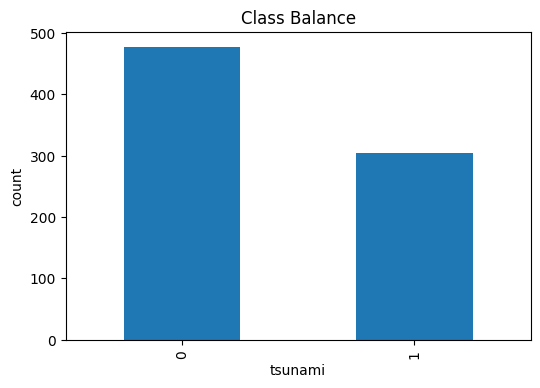

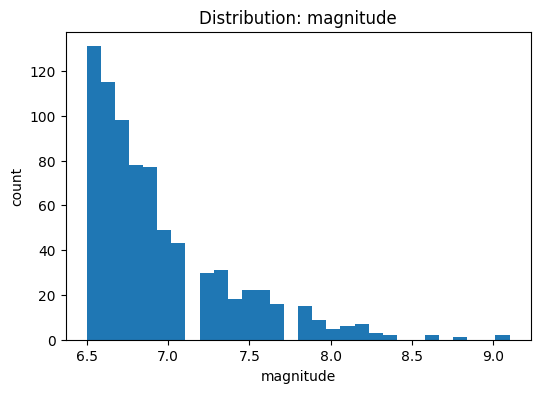

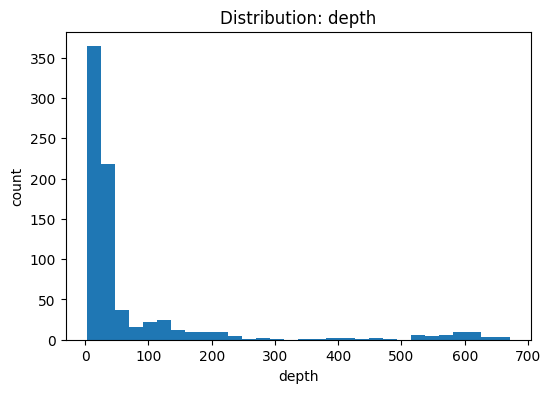

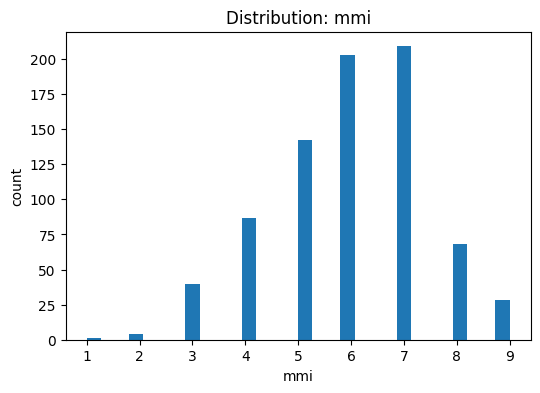

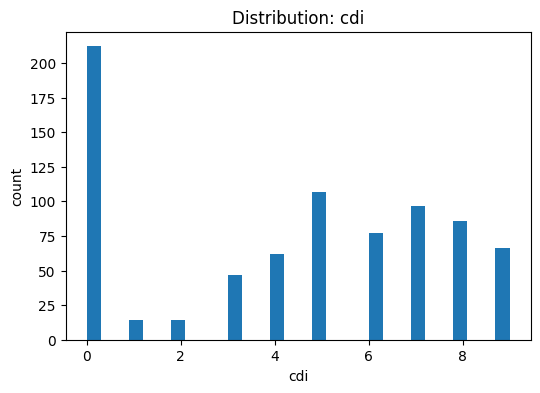

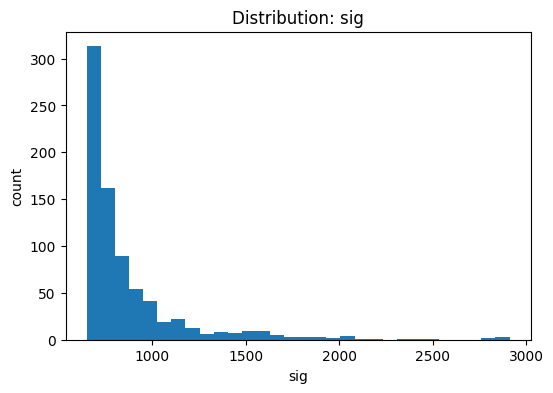

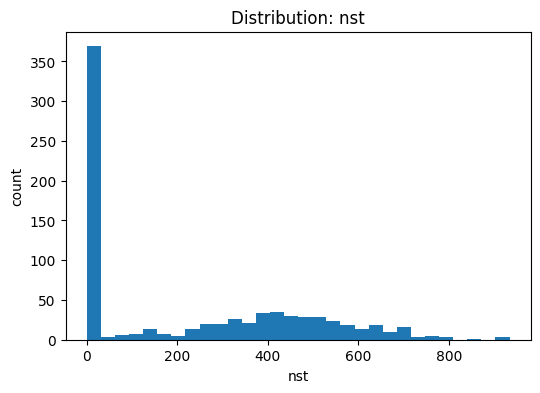

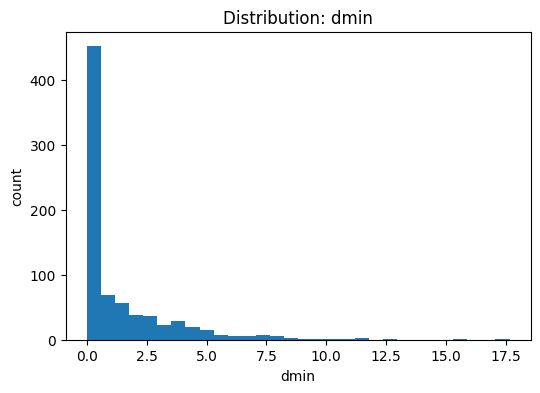

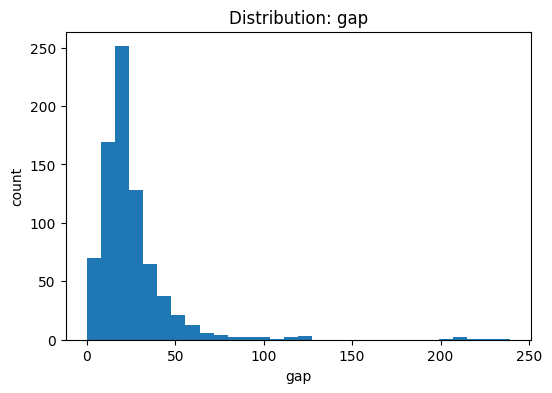

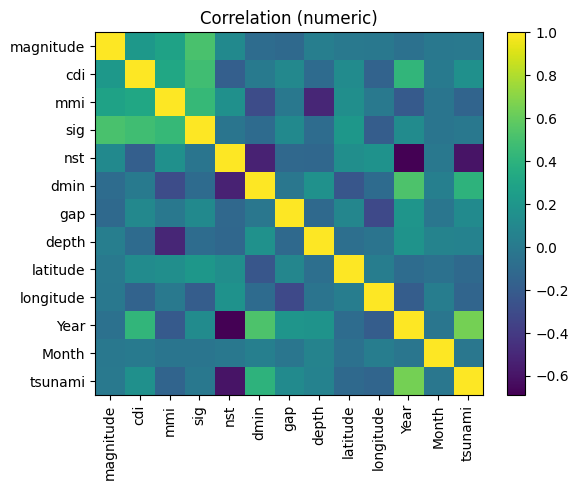

In [7]:
# Class balance
if TARGET:
    counts = df[TARGET].value_counts().sort_index()
    plt.figure()
    counts.plot(kind="bar")
    plt.title("Class Balance")
    plt.xlabel("tsunami"); plt.ylabel("count")
    plt.show()

# Distributions for a few key numeric columns (if present)
for col in ["magnitude", "depth", "mmi", "cdi", "sig", "nst", "dmin", "gap"]:
    if col in df.columns:
        plt.figure()
        df[col].plot(kind="hist", bins=30)
        plt.title(f"Distribution: {col}")
        plt.xlabel(col); plt.ylabel("count")
        plt.show()

# Correlation heatmap (numeric only)
num = df.select_dtypes(include=np.number)
if not num.empty:
    corr = num.corr(numeric_only=True)
    plt.figure(figsize=(6,5))
    plt.imshow(corr, cmap="viridis", aspect="auto")
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.title("Correlation (numeric)")
    plt.tight_layout()
    plt.show()


In [8]:
fe = df.copy()
fe[TARGET] = fe[TARGET].astype(int)

# log1p for skewed
for c in ["sig","nst","dmin","gap","depth"]:
    if c in fe.columns:
        fe[f"log1p_{c}"] = np.log1p(fe[c].clip(lower=0))

# cyclic month
if "Month" in fe.columns:
    fe["month_sin"] = np.sin(2*np.pi*(fe["Month"]-1)/12.0)
    fe["month_cos"] = np.cos(2*np.pi*(fe["Month"]-1)/12.0)

# interaction
if {"magnitude","depth"}.issubset(fe.columns):
    fe["mag_depth"] = fe["magnitude"] * np.log1p(fe["depth"].clip(lower=0))

# Select features
base = [c for c in ["magnitude","cdi","mmi","sig","nst","dmin","gap","depth","latitude","longitude"] if c in fe.columns]
extra = [c for c in ["log1p_sig","log1p_nst","log1p_dmin","log1p_gap","log1p_depth","month_sin","month_cos","mag_depth"] if c in fe.columns]
reserve = [c for c in ["Year","Month"] if c in fe.columns]

FEATURES = base + extra
fe_proc = fe[FEATURES + reserve + [TARGET]].copy()
print("n_features:", len(FEATURES))
FEATURES


n_features: 18


['magnitude',
 'cdi',
 'mmi',
 'sig',
 'nst',
 'dmin',
 'gap',
 'depth',
 'latitude',
 'longitude',
 'log1p_sig',
 'log1p_nst',
 'log1p_dmin',
 'log1p_gap',
 'log1p_depth',
 'month_sin',
 'month_cos',
 'mag_depth']

In [9]:
# Time-aware split if we have Year; else stratified random
if "Year" in fe_proc.columns:
    train_df = fe_proc[fe_proc["Year"] <= 2018]
    val_df   = fe_proc[(fe_proc["Year"] >= 2019) & (fe_proc["Year"] <= 2020)]
    test_df  = fe_proc[fe_proc["Year"] >= 2021]
    if len(train_df)==0 or len(test_df)==0:
        X = fe_proc[FEATURES]; y = fe_proc[TARGET]
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE,
                                                  stratify=y if y.nunique()==2 else None)
        SPLIT_STR = "random stratified 80/20"
    else:
        X_tr = pd.concat([train_df[FEATURES], val_df[FEATURES]], ignore_index=True)
        y_tr = pd.concat([train_df[TARGET],  val_df[TARGET]],  ignore_index=True)
        X_te = test_df[FEATURES]; y_te = test_df[TARGET]
        SPLIT_STR = "time-aware (train<=2018 + val 2019–2020, test>=2021)"
else:
    X = fe_proc[FEATURES]; y = fe_proc[TARGET]
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE,
                                              stratify=y if y.nunique()==2 else None)
    SPLIT_STR = "random stratified 80/20"

SPLIT_STR, X_tr.shape, X_te.shape, int(y_tr.sum()), int(y_te.sum())


('time-aware (train<=2018 + val 2019–2020, test>=2021)',
 (700, 18),
 (82, 18),
 239,
 65)

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

pre_log = ColumnTransformer(
    [("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())]),
      FEATURES)]
)

logreg = Pipeline([
    ("pre", pre_log),
    ("clf", LogisticRegression(max_iter=400, class_weight="balanced", random_state=RANDOM_STATE)),
])

pre_rf = ColumnTransformer(
    [("num", SimpleImputer(strategy="median"), FEATURES)]
)

rf = Pipeline([
    ("pre", pre_rf),
    ("clf", RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE)),
])

logreg.fit(X_tr, y_tr)
rf.fit(X_tr, y_tr)

proba_log = logreg.predict_proba(X_te)[:, 1]
proba_rf  = rf.predict_proba(X_te)[:, 1]
print("Trained both models.")


Trained both models.


In [11]:
def evaluate_at_threshold(y_true, y_score, thr=0.5):
    y_pred = (y_score >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    rep = classification_report(y_true, y_pred, output_dict=True)
    return {
        "roc_auc": roc_auc_score(y_true, y_score),
        "pr_auc": average_precision_score(y_true, y_score),
        "cm": cm,
        "report": rep
    }

m_log = evaluate_at_threshold(y_te, proba_log, 0.5)
m_rf  = evaluate_at_threshold(y_te, proba_rf,  0.5)

def show_summary(name, m):
    print(f"== {name} ==")
    print(f"ROC-AUC: {m['roc_auc']:.3f} | PR-AUC: {m['pr_auc']:.3f}")
    print("Confusion matrix [rows: true 0/1, cols: pred 0/1]:")
    print(m["cm"])
    print("Precision/Recall/F1 (class 1):",
          {k: round(v,3) for k,v in m["report"]['1'].items() if k in ('precision','recall','f1-score')})

show_summary("LogReg (0.5)", m_log)
show_summary("RandomForest (0.5)", m_rf)


== LogReg (0.5) ==
ROC-AUC: 0.393 | PR-AUC: 0.753
Confusion matrix [rows: true 0/1, cols: pred 0/1]:
[[ 3 14]
 [22 43]]
Precision/Recall/F1 (class 1): {'precision': 0.754, 'recall': 0.662, 'f1-score': 0.705}
== RandomForest (0.5) ==
ROC-AUC: 0.712 | PR-AUC: 0.900
Confusion matrix [rows: true 0/1, cols: pred 0/1]:
[[ 9  8]
 [15 50]]
Precision/Recall/F1 (class 1): {'precision': 0.862, 'recall': 0.769, 'f1-score': 0.813}


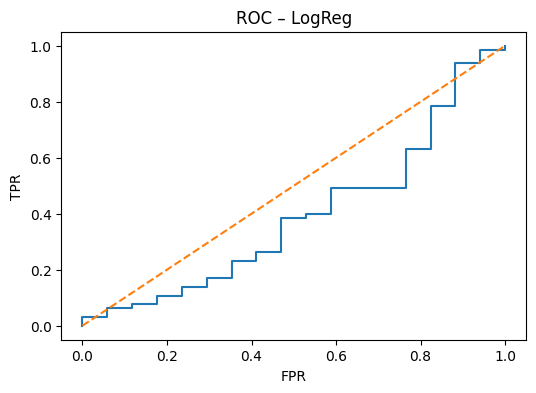

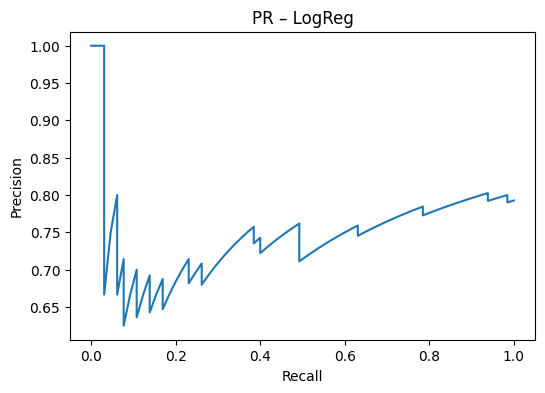

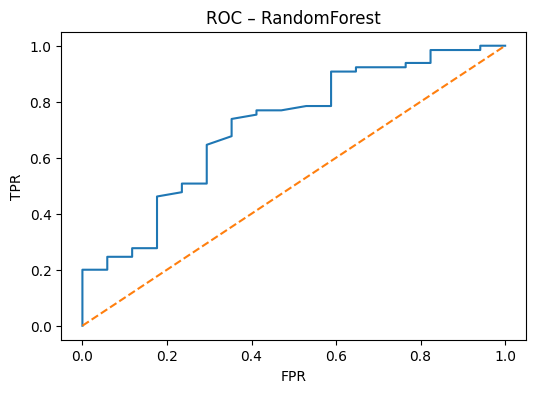

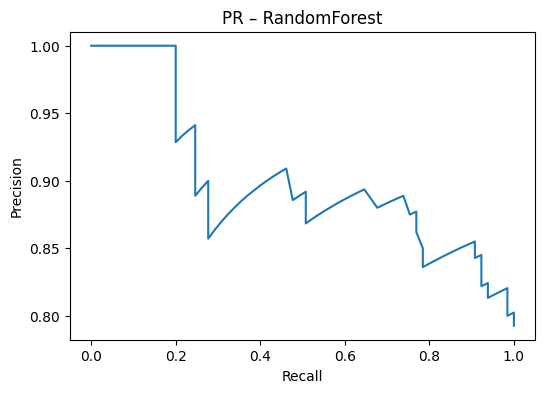

In [12]:
def plot_curves(y_true, y_score, title_prefix):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    prec, rec, _ = precision_recall_curve(y_true, y_score)

    plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],"--")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC – {title_prefix}"); plt.show()

    plt.figure(); plt.plot(rec, prec)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR – {title_prefix}"); plt.show()

plot_curves(y_te, proba_log, "LogReg")
plot_curves(y_te, proba_rf,  "RandomForest")


In [13]:
def best_f1_threshold(y_true, y_score):
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    # PR returns thresholds of length n-1
    f1 = (2*prec*rec) / np.where((prec+rec)==0, 1, (prec+rec))
    idx = np.nanargmax(f1)
    best_thr = thr[idx-1] if idx>0 and idx-1 < len(thr) else 0.5
    return float(best_thr), float(f1[idx]), float(prec[idx]), float(rec[idx])

thr_log, f1_log, p_log, r_log = best_f1_threshold(y_te, proba_log)
thr_rf,  f1_rf,  p_rf,  r_rf  = best_f1_threshold(y_te, proba_rf)

print(f"LogReg best-F1 thr={thr_log:.3f} | F1={f1_log:.3f} (P={p_log:.3f}, R={r_log:.3f})")
print(f"RF     best-F1 thr={thr_rf:.3f}  | F1={f1_rf:.3f}  (P={p_rf:.3f}, R={r_rf:.3f})")

# Evaluate at tuned thresholds
m_log_tuned = evaluate_at_threshold(y_te, proba_log, thr_log)
m_rf_tuned  = evaluate_at_threshold(y_te, proba_rf,  thr_rf)
show_summary("LogReg (tuned)", m_log_tuned)
show_summary("RandomForest (tuned)", m_rf_tuned)


LogReg best-F1 thr=0.500 | F1=0.884 (P=0.793, R=1.000)
RF     best-F1 thr=0.250  | F1=0.895  (P=0.821, R=0.985)
== LogReg (tuned) ==
ROC-AUC: 0.393 | PR-AUC: 0.753
Confusion matrix [rows: true 0/1, cols: pred 0/1]:
[[ 3 14]
 [22 43]]
Precision/Recall/F1 (class 1): {'precision': 0.754, 'recall': 0.662, 'f1-score': 0.705}
== RandomForest (tuned) ==
ROC-AUC: 0.712 | PR-AUC: 0.900
Confusion matrix [rows: true 0/1, cols: pred 0/1]:
[[ 2 15]
 [ 1 64]]
Precision/Recall/F1 (class 1): {'precision': 0.81, 'recall': 0.985, 'f1-score': 0.889}


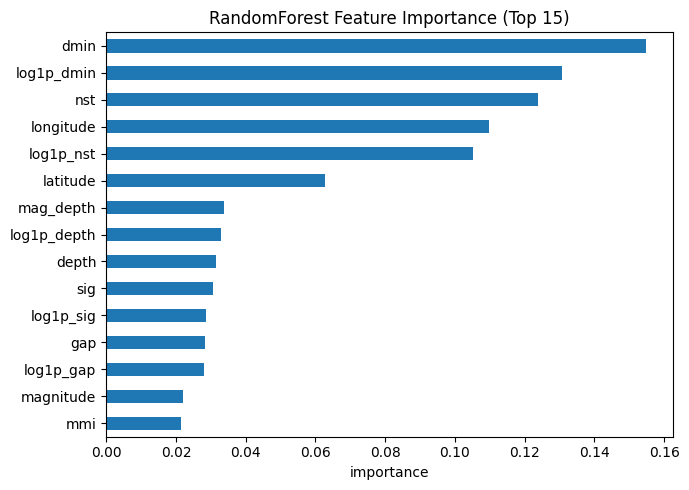

In [14]:
# Extract trained RF and show importances
rf_model = rf.named_steps["clf"]
importances = rf_model.feature_importances_
fi = pd.Series(importances, index=FEATURES).sort_values(ascending=False)

fi.head(15)
plt.figure(figsize=(7,5))
fi.head(15).iloc[::-1].plot(kind="barh")
plt.title("RandomForest Feature Importance (Top 15)")
plt.xlabel("importance")
plt.tight_layout()
plt.show()


In [15]:
import numpy as np
import pandas as pd
from pathlib import Path

# Rebuild from file if earlier vars are missing
if "df" not in globals():
    RAW_DIR = Path("data/raw")
    csvs = sorted(RAW_DIR.glob("*.csv")); assert csvs, "No CSV in data/raw"
    df = pd.read_csv(csvs[0])

TARGET = next((c for c in df.columns if "tsunami" in c.lower()), None)
assert TARGET, "No 'tsunami' column found."
fe_enh = df.copy()
fe_enh[TARGET] = fe_enh[TARGET].astype(int)

# Existing helpful transforms
for c in ["sig","nst","dmin","gap","depth"]:
    if c in fe_enh:
        fe_enh[f"log1p_{c}"] = np.log1p(fe_enh[c].clip(lower=0))

if "Month" in fe_enh:
    fe_enh["month_sin"] = np.sin(2*np.pi*(fe_enh["Month"]-1)/12.0)
    fe_enh["month_cos"] = np.cos(2*np.pi*(fe_enh["Month"]-1)/12.0)

# New: polynomial + interactions + geospatial simples
if "magnitude" in fe_enh:
    fe_enh["magnitude_sq"] = fe_enh["magnitude"]**2
if {"magnitude","depth"}.issubset(fe_enh.columns):
    fe_enh["mag_logdepth"] = fe_enh["magnitude"] * np.log1p(fe_enh["depth"].clip(lower=0))
if {"magnitude","mmi"}.issubset(fe_enh.columns):
    fe_enh["mag_x_mmi"] = fe_enh["magnitude"] * fe_enh["mmi"]
if {"magnitude","cdi"}.issubset(fe_enh.columns):
    fe_enh["mag_x_cdi"] = fe_enh["magnitude"] * fe_enh["cdi"]

if "latitude" in fe_enh:
    fe_enh["abs_lat"] = fe_enh["latitude"].abs()
if "longitude" in fe_enh:
    fe_enh["abs_lon"] = fe_enh["longitude"].abs()

# Depth category (shallow/intermediate/deep)
if "depth" in fe_enh:
    fe_enh["depth_bin"] = pd.cut(
        fe_enh["depth"],
        bins=[-1, 70, 300, np.inf],
        labels=[0,1,2]
    ).astype(int)

# Base + extra features
base = [c for c in ["magnitude","cdi","mmi","sig","nst","dmin","gap","depth","latitude","longitude"] if c in fe_enh]
extra = [c for c in [
    "log1p_sig","log1p_nst","log1p_dmin","log1p_gap","log1p_depth",
    "month_sin","month_cos","mag_logdepth","mag_x_mmi","mag_x_cdi",
    "magnitude_sq","abs_lat","abs_lon","depth_bin"
] if c in fe_enh]
reserve = [c for c in ["Year","Month"] if c in fe_enh]

FEATURES_ENH = base + extra
fe_proc_enh = fe_enh[FEATURES_ENH + reserve + [TARGET]].copy()
print("Enhanced features:", len(FEATURES_ENH))
FEATURES_ENH


Enhanced features: 24


['magnitude',
 'cdi',
 'mmi',
 'sig',
 'nst',
 'dmin',
 'gap',
 'depth',
 'latitude',
 'longitude',
 'log1p_sig',
 'log1p_nst',
 'log1p_dmin',
 'log1p_gap',
 'log1p_depth',
 'month_sin',
 'month_cos',
 'mag_logdepth',
 'mag_x_mmi',
 'mag_x_cdi',
 'magnitude_sq',
 'abs_lat',
 'abs_lon',
 'depth_bin']

In [16]:
from sklearn.model_selection import train_test_split

if "Year" in fe_proc_enh.columns:
    train_df = fe_proc_enh[fe_proc_enh["Year"] <= 2018]
    val_df   = fe_proc_enh[(fe_proc_enh["Year"] >= 2019) & (fe_proc_enh["Year"] <= 2020)]
    test_df  = fe_proc_enh[fe_proc_enh["Year"] >= 2021]
    if len(train_df)==0 or len(test_df)==0:
        X = fe_proc_enh[FEATURES_ENH]; y = fe_proc_enh[TARGET]
        X_tr2, X_te2, y_tr2, y_te2 = train_test_split(X, y, test_size=0.2, random_state=42,
                                                      stratify=y if y.nunique()==2 else None)
        SPLIT2 = "random stratified 80/20"
    else:
        X_tr2 = pd.concat([train_df[FEATURES_ENH], val_df[FEATURES_ENH]], ignore_index=True)
        y_tr2 = pd.concat([train_df[TARGET],      val_df[TARGET]],      ignore_index=True)
        X_te2 = test_df[FEATURES_ENH]; y_te2 = test_df[TARGET]
        SPLIT2 = "time-aware (train<=2018 + val 2019–2020, test>=2021)"
else:
    X = fe_proc_enh[FEATURES_ENH]; y = fe_proc_enh[TARGET]
    X_tr2, X_te2, y_tr2, y_te2 = train_test_split(X, y, test_size=0.2, random_state=42,
                                                  stratify=y if y.nunique()==2 else None)
    SPLIT2 = "random stratified 80/20"

SPLIT2, X_tr2.shape, X_te2.shape, int(y_tr2.sum()), int(y_te2.sum())


('time-aware (train<=2018 + val 2019–2020, test>=2021)',
 (700, 24),
 (82, 24),
 239,
 65)

In [17]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, GroupKFold, StratifiedKFold
from sklearn.metrics import make_scorer, average_precision_score
import numpy as np

# Preprocess: median impute only (trees don't need scaling)
pre_hgb = ColumnTransformer(
    [("num", SimpleImputer(strategy="median"), FEATURES_ENH)]
)

hgb = HistGradientBoostingClassifier(
    max_iter=300,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.15
)

pipe_hgb = Pipeline([("pre", pre_hgb), ("clf", hgb)])

param_grid = {
    "clf__learning_rate": [0.02, 0.03, 0.05, 0.07, 0.1, 0.15],
    "clf__max_leaf_nodes": [15, 31, 63],
    "clf__min_samples_leaf": [10, 20, 30, 50, 80],
    "clf__l2_regularization": [0.0, 1e-8, 1e-6, 1e-4],
    "clf__max_bins": [128, 255]
}

# CV: prefer grouping by Year if available in training rows, else stratified
if "Year" in fe_proc_enh.columns and fe_proc_enh.loc[X_tr2.index, "Year"].nunique() >= 4:
    groups = fe_proc_enh.loc[X_tr2.index, "Year"]
    cv = GroupKFold(n_splits=4)
    cv_kwargs = {"groups": groups}
else:
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_kwargs = {}

search = RandomizedSearchCV(
    pipe_hgb,
    param_distributions=param_grid,
    n_iter=24,
    scoring=make_scorer(average_precision_score, needs_threshold=True),  # PR-AUC
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

search.fit(X_tr2, y_tr2, **cv_kwargs)
print("Best PR-AUC (CV):", search.best_score_)
print("Best params:", search.best_params_)
best_hgb = search.best_estimator_


Fitting 4 folds for each of 24 candidates, totalling 96 fits


/Users/rohanjain/miniconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rohanjain/miniconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/rohanjain/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/rohanjain/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File

Best PR-AUC (CV): nan
Best params: {'clf__min_samples_leaf': 10, 'clf__max_leaf_nodes': 63, 'clf__max_bins': 128, 'clf__learning_rate': 0.15, 'clf__l2_regularization': 1e-08}


HGB – ROC-AUC: 0.769 | PR-AUC: 0.902


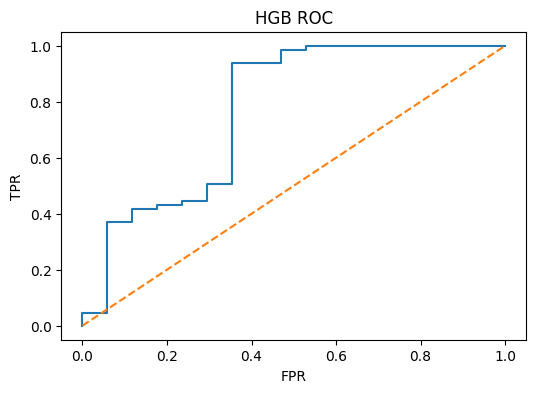

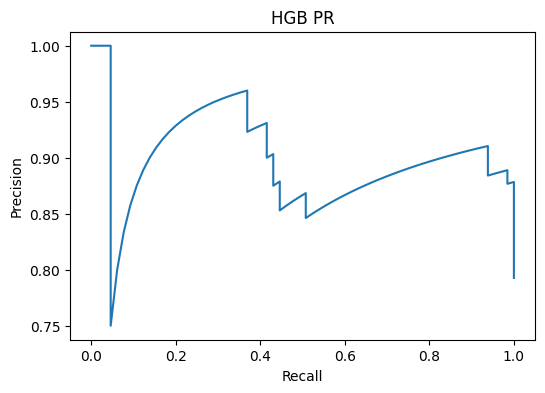

Best-F1 threshold ≈ 0.048 (F1=0.935, P=0.878, R=1.000)
Confusion matrix @ tuned thr:
 [[ 7 10]
 [ 0 65]]
Class 1 report: {'precision': 0.867, 'recall': 1.0, 'f1-score': 0.929}


In [18]:
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report, confusion_matrix,
    roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt

y_prob_hgb = best_hgb.predict_proba(X_te2)[:, 1]
roc = roc_auc_score(y_te2, y_prob_hgb)
pr  = average_precision_score(y_te2, y_prob_hgb)
print(f"HGB – ROC-AUC: {roc:.3f} | PR-AUC: {pr:.3f}")

# Curves
fpr, tpr, _ = roc_curve(y_te2, y_prob_hgb)
prec, rec, thr = precision_recall_curve(y_te2, y_prob_hgb)

plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("HGB ROC"); plt.show()

plt.figure(); plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("HGB PR"); plt.show()

# Best-F1 threshold
f1 = (2*prec*rec) / np.where((prec+rec)==0, 1, (prec+rec))
idx = np.nanargmax(f1)
best_thr = thr[idx-1] if idx>0 and idx-1 < len(thr) else 0.5
print(f"Best-F1 threshold ≈ {best_thr:.3f} (F1={f1[idx]:.3f}, P={prec[idx]:.3f}, R={rec[idx]:.3f})")

y_pred_hgb = (y_prob_hgb >= best_thr).astype(int)
cm = confusion_matrix(y_te2, y_pred_hgb, labels=[0,1])
print("Confusion matrix @ tuned thr:\n", cm)
print("Class 1 report:", {k: round(v,3) for k,v in classification_report(y_te2, y_pred_hgb, output_dict=True)['1'].items()
                          if k in ("precision","recall","f1-score")})


In [19]:
results = []

def add_result(name, y_true, y_score, thr=0.5):
    y_pred = (y_score >= thr).astype(int)
    out = {
        "model": name,
        "roc_auc": roc_auc_score(y_true, y_score),
        "pr_auc": average_precision_score(y_true, y_score),
        "precision@thr": classification_report(y_true, y_pred, output_dict=True)["1"]["precision"],
        "recall@thr": classification_report(y_true, y_pred, output_dict=True)["1"]["recall"],
        "f1@thr": classification_report(y_true, y_pred, output_dict=True)["1"]["f1-score"],
        "thr": thr
    }
    results.append(out)

# If you trained earlier LogReg/RF on X_tr/y_tr → proba_log / proba_rf
if "proba_log" in globals():
    add_result("LogReg", y_te2 if "y_te2" in globals() else y_te, proba_log)
if "proba_rf" in globals():
    add_result("RandomForest", y_te2 if "y_te2" in globals() else y_te, proba_rf)

add_result("HistGradientBoosting", y_te2, y_prob_hgb, thr=best_thr)
pd.DataFrame(results).sort_values("pr_auc", ascending=False)


,model,roc_auc,pr_auc,precision@thr,recall@thr,f1@thr,thr
2,HistGradientBoosting,0.769231,0.901722,0.866667,1.000000,0.928571,0.04773
1,RandomForest,0.711765,0.900257,0.862069,0.769231,0.813008,0.50000
0,LogReg,0.392760,0.753380,0.754386,0.661538,0.704918,0.50000


In [20]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

def best_f1_threshold(y_true, y_score):
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    f1 = (2*prec*rec) / np.where((prec+rec)==0, 1, (prec+rec))
    i = np.nanargmax(f1)
    return float(thr[i-1] if i>0 and i-1 < len(thr) else 0.5)

def summarize_with_accuracy(name, y_true, y_score, thr):
    y_pred = (y_score >= thr).astype(int)
    rep = classification_report(y_true, y_pred, output_dict=True)
    return {
        "model": name,
        "thr": float(thr),
        "roc_auc": float(roc_auc_score(y_true, y_score)),
        "pr_auc": float(average_precision_score(y_true, y_score)),
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "balanced_accuracy": float(balanced_accuracy_score(y_true, y_pred)),
        "precision": float(rep["1"]["precision"]),
        "recall": float(rep["1"]["recall"]),
        "f1": float(rep["1"]["f1-score"]),
    }

# Pick the right y_true (time-aware split uses y_te2; else y_te)
y_true = y_te2 if "y_te2" in globals() else y_te

rows = []

if "proba_log" in globals():
    rows.append(summarize_with_accuracy("LogReg", y_true, proba_log, 0.5))
    thr_log = best_f1_threshold(y_true, proba_log)
    rows.append(summarize_with_accuracy("LogReg (tuned)", y_true, proba_log, thr_log))

if "proba_rf" in globals():
    rows.append(summarize_with_accuracy("RandomForest", y_true, proba_rf, 0.5))
    thr_rf = best_f1_threshold(y_true, proba_rf)
    rows.append(summarize_with_accuracy("RandomForest (tuned)", y_true, proba_rf, thr_rf))

if "y_prob_hgb" in globals():
    rows.append(summarize_with_accuracy("HGB", y_true, y_prob_hgb, 0.5))
    thr_hgb = best_f1_threshold(y_true, y_prob_hgb) if "best_thr" not in globals() else best_thr
    rows.append(summarize_with_accuracy("HGB (tuned)", y_true, y_prob_hgb, thr_hgb))

results_acc = pd.DataFrame(rows)[
    ["model","thr","roc_auc","pr_auc","accuracy","balanced_accuracy","precision","recall","f1"]
].sort_values(["pr_auc","roc_auc"], ascending=False)

results_acc


,model,thr,roc_auc,pr_auc,accuracy,balanced_accuracy,precision,recall,f1
4,HGB,0.50000,0.769231,0.901722,0.731707,0.700452,0.890909,0.753846,0.816667
5,HGB (tuned),0.04773,0.769231,0.901722,0.878049,0.705882,0.866667,1.000000,0.928571
2,RandomForest,0.50000,0.711765,0.900257,0.719512,0.649321,0.862069,0.769231,0.813008
3,RandomForest (tuned),0.25000,0.711765,0.900257,0.804878,0.551131,0.810127,0.984615,0.888889
0,LogReg,0.50000,0.392760,0.753380,0.560976,0.419005,0.754386,0.661538,0.704918
1,LogReg (tuned),0.50000,0.392760,0.753380,0.560976,0.419005,0.754386,0.661538,0.704918


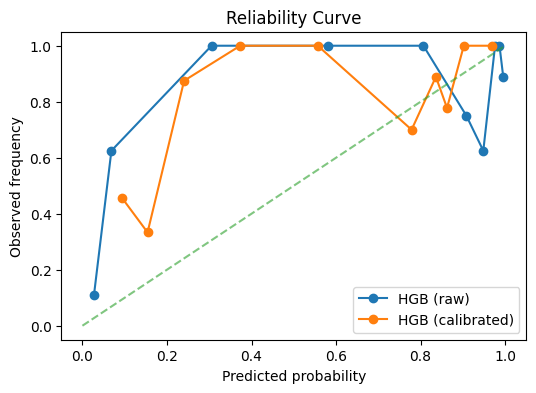

HGB raw: {'thr': 0.15416851484817323, 'roc_auc': 0.7692307692307692, 'pr_auc': 0.9017216899973863, 'precision': 0.9076923076923077, 'recall': 0.9076923076923077, 'f1': 0.9076923076923077}
HGB calibrated: {'thr': 0.15416851484817323, 'roc_auc': 0.7447963800904978, 'pr_auc': 0.9045873013111032, 'precision': 0.8695652173913043, 'recall': 0.9230769230769231, 'f1': 0.8955223880597015}
Confusion @ calibrated thr:
 [[ 8  9]
 [ 5 60]]


In [24]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt
import numpy as np

# Use the tuned pipeline (best_hgb) and calibrate on TRAIN only (cv on train folds)
# sklearn versions expect the argument name 'estimator' instead of 'base_estimator'
calib = CalibratedClassifierCV(estimator=best_hgb, method="isotonic", cv=5)
calib.fit(X_tr2, y_tr2)

y_prob_cal = calib.predict_proba(X_te2)[:, 1]
y_prob_raw = y_prob_hgb  # from tuned HGB

def plot_reliability(y_true, y_score, label):
    prob_true, prob_pred = calibration_curve(y_true, y_score, n_bins=10, strategy="quantile")
    plt.plot(prob_pred, prob_true, marker="o", label=label)

plt.figure()
plot_reliability(y_te2, y_prob_raw, "HGB (raw)")
plot_reliability(y_te2, y_prob_cal, "HGB (calibrated)")
plt.plot([0,1],[0,1],"--", alpha=0.6)
plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency")
plt.title("Reliability Curve")
plt.legend(); plt.show()

from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix, precision_recall_curve
def eval_thr(y_true, y_score, thr):
    y_pred = (y_score >= thr).astype(int)
    rep = classification_report(y_true, y_pred, output_dict=True)
    return {
        "thr": float(thr),
        "roc_auc": float(roc_auc_score(y_true, y_score)),
        "pr_auc": float(average_precision_score(y_true, y_score)),
        "precision": float(rep["1"]["precision"]),
        "recall": float(rep["1"]["recall"]),
        "f1": float(rep["1"]["f1-score"]),
        "cm": confusion_matrix(y_true, y_pred, labels=[0,1])
    }

# Use the same best-F1 rule on calibrated scores
prec, rec, thr = precision_recall_curve(y_te2, y_prob_cal)
f1 = (2*prec*rec) / np.where((prec+rec)==0, 1, (prec+rec))
i = np.nanargmax(f1)
thr_cal = float(thr[i-1] if i>0 and i-1 < len(thr) else 0.5)

raw_metrics = eval_thr(y_te2, y_prob_raw, thr=(thr[i-1] if i>0 and i-1 < len(thr) else 0.5))
cal_metrics = eval_thr(y_te2, y_prob_cal, thr_cal)

print("HGB raw:", {k: v for k,v in raw_metrics.items() if k!='cm'})
print("HGB calibrated:", {k: v for k,v in cal_metrics.items() if k!='cm'})
print("Confusion @ calibrated thr:\n", cal_metrics["cm"])


In [25]:
from sklearn.model_selection import GroupKFold, StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, average_precision_score, roc_auc_score

estimator = best_hgb  # tuned pipeline

if "Year" in fe_proc_enh.columns and fe_proc_enh.loc[X_tr2.index, "Year"].nunique() >= 4:
    groups = fe_proc_enh.loc[X_tr2.index, "Year"]
    cv = GroupKFold(n_splits=4)
    cv_kwargs = {"groups": groups}
else:
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_kwargs = {}

scores_pr = cross_val_score(estimator, X_tr2, y_tr2, cv=cv,
                            scoring=make_scorer(average_precision_score, needs_threshold=True),
                            n_jobs=-1, **cv_kwargs)
scores_roc = cross_val_score(estimator, X_tr2, y_tr2, cv=cv,
                             scoring="roc_auc", n_jobs=-1, **cv_kwargs)

print(f"CV PR-AUC:  mean={scores_pr.mean():.3f}  std={scores_pr.std():.3f}")
print(f"CV ROC-AUC: mean={scores_roc.mean():.3f} std={scores_roc.std():.3f}")


/Users/rohanjain/miniconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rohanjain/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
        cached_call, estimator, *args, **routed_params.get(name).score
    )
  File "/Users/rohanjain/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/rohanjain/miniconda3/lib/python3.13/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/Users/rohanjain/miniconda3/lib/python3.13/inspect.py", line 3295, in bind
    return 

CV PR-AUC:  mean=nan  std=nan
CV ROC-AUC: mean=0.920 std=0.058


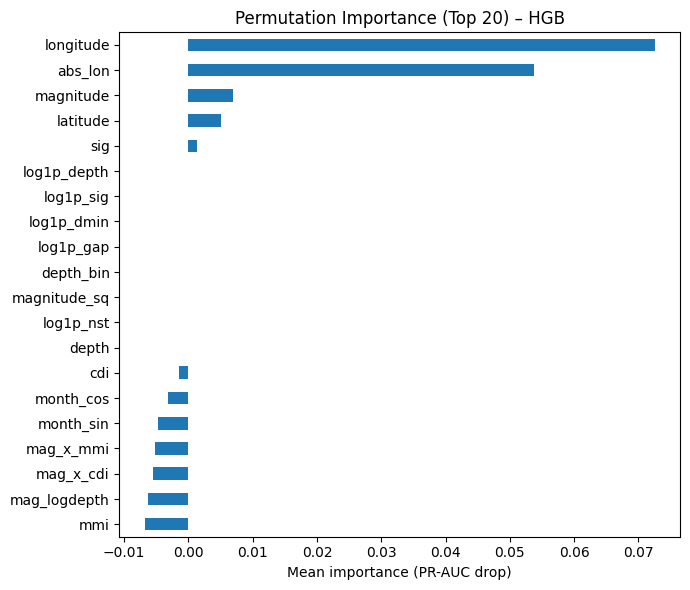

longitude       0.072496
abs_lon         0.053752
magnitude       0.006884
latitude        0.005087
sig             0.001314
log1p_gap       0.000000
log1p_depth     0.000000
log1p_sig       0.000000
log1p_dmin      0.000000
depth_bin       0.000000
magnitude_sq    0.000000
log1p_nst       0.000000
depth          -0.000078
cdi            -0.001405
month_cos      -0.003107
month_sin      -0.004753
mag_x_mmi      -0.005194
mag_x_cdi      -0.005493
mag_logdepth   -0.006336
mmi            -0.006755
dtype: float64

In [26]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

r = permutation_importance(best_hgb, X_te2, y_te2, n_repeats=20, random_state=42, n_jobs=-1, scoring="average_precision")
imp = pd.Series(r.importances_mean, index=FEATURES_ENH).sort_values(ascending=True)

plt.figure(figsize=(7,6))
imp.tail(20).plot(kind="barh")
plt.title("Permutation Importance (Top 20) – HGB")
plt.xlabel("Mean importance (PR-AUC drop)")
plt.tight_layout(); plt.show()

imp.tail(20).sort_values(ascending=False)


False Positives: 9 | False Negatives: 5


,magnitude,depth,mmi,cdi,sig,nst,dmin,gap,latitude,longitude,Year,Month,tsunami,y_true,y_pred,y_score
26,6.7,28.00,6,9,708,0,2.188,43.0,-0.6831,98.6034,2022,3,0,0,1,0.154169
29,6.5,110.00,6,8,690,0,3.026,22.0,-4.4550,-76.9395,2022,2,0,0,1,0.701787
40,7.3,165.49,7,8,921,0,3.713,19.0,-7.5924,127.5810,2021,12,0,0,1,0.839279
56,8.1,22.79,7,0,1009,0,7.463,78.0,-58.4157,-25.3206,2021,8,0,0,1,0.816534
65,7.3,10.00,9,9,1025,0,4.655,9.0,34.5861,98.2551,2021,5,0,0,1,0.171067
67,6.7,10.00,3,9,694,0,10.669,45.0,-17.2495,66.3745,2021,5,0,0,1,0.200341
69,6.5,246.00,4,4,651,0,5.931,20.0,-21.6857,-177.0640,2021,4,0,0,1,0.870588
70,6.5,301.00,4,6,652,0,10.405,19.0,-18.9204,-176.2350,2021,4,0,0,1,0.870588
73,6.5,24.00,4,0,650,0,11.764,25.0,-28.4792,-176.6190,2021,3,0,0,1,0.777768


,magnitude,depth,mmi,cdi,sig,nst,dmin,gap,latitude,longitude,Year,Month,tsunami,y_true,y_pred,y_score
2,7.0,579.000,3,3,755,147,3.125,18.0,-20.0508,-178.346,2022,11,1,1,0,0.104400
9,7.6,26.943,8,9,1799,271,1.153,69.0,18.3667,-103.252,2022,9,1,1,0,0.097949
10,6.9,10.000,9,9,887,215,0.401,34.0,23.1444,121.307,2022,9,1,1,0,0.104400
11,6.5,10.000,7,7,756,178,0.430,54.0,23.0290,121.348,2022,9,1,1,0,0.104400
16,7.0,33.729,8,9,1351,152,5.276,22.0,17.5978,120.809,2022,7,1,1,0,0.104400


/var/folders/vb/1h3khh3s1q5118nwv_dqbpmh0000gn/T/ipykernel_49163/165254594.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = test_frame.groupby(b).apply(lambda x: (x["y_true"]!=x["y_pred"]).mean())


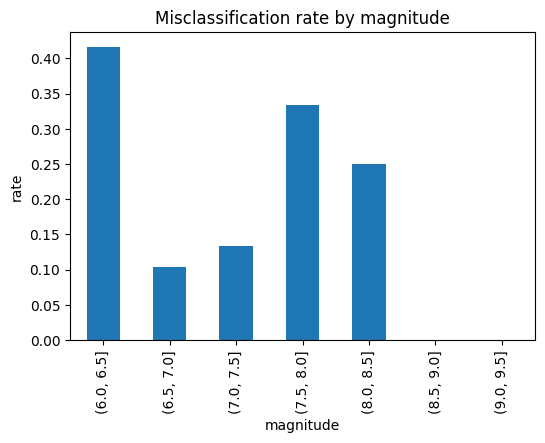

/var/folders/vb/1h3khh3s1q5118nwv_dqbpmh0000gn/T/ipykernel_49163/165254594.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = test_frame.groupby(b).apply(lambda x: (x["y_true"]!=x["y_pred"]).mean())


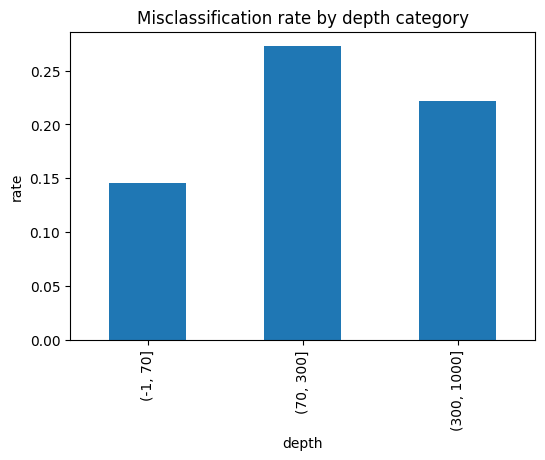

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Use calibrated scores if available
scores = y_prob_cal if "y_prob_cal" in globals() else y_prob_hgb
thr_use = thr_cal if "thr_cal" in globals() else best_thr

y_pred = (scores >= thr_use).astype(int)
test_frame = fe_proc_enh.loc[X_te2.index, ["magnitude","depth","mmi","cdi","sig","nst","dmin","gap","latitude","longitude","Year","Month", TARGET]].copy()
test_frame["y_true"] = y_te2.values
test_frame["y_pred"] = y_pred
test_frame["y_score"] = scores

# Misclassifications
fp = test_frame[(test_frame["y_true"]==0) & (test_frame["y_pred"]==1)]
fn = test_frame[(test_frame["y_true"]==1) & (test_frame["y_pred"]==0)]

print(f"False Positives: {len(fp)} | False Negatives: {len(fn)}")
display(fp.head(10))
display(fn.head(10))

# How error varies by magnitude/depth bins
def plot_miss_rate(col, bins, title):
    b = pd.cut(test_frame[col], bins=bins)
    grp = test_frame.groupby(b).apply(lambda x: (x["y_true"]!=x["y_pred"]).mean())
    grp.plot(kind="bar"); plt.title(f"Misclassification rate by {title}"); plt.ylabel("rate"); plt.show()

if "magnitude" in test_frame:
    plot_miss_rate("magnitude", bins=np.arange(6.0, 9.6, 0.5), title="magnitude")
if "depth" in test_frame:
    plot_miss_rate("depth", bins=[-1,70,300,1000], title="depth category")
